# Fashion MNIST Classification CNN with PyTorch
Build a convolutional neural network to classify fashion images, and view the results using TensorBoard.

In [11]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

In [12]:
# check PyTorch versions
print(torch.__version__)
print(torchvision.__version__)

1.3.1
0.4.2


### Load training data
Torchvision consists of popular datasets, model architectures, and common image transformations for computer vision.

Datasets avaiable include MNIST, Fashion-MNIST, ImageNet, CIFAR. Torchvision also includes a number of popular model architectures.

In [0]:
# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)


## Neural network architecture
All networks are classes, built from the nn.Module. The init function defines the general architecture, forward defines the forward pass from input to output.

For homework exercises, the main changes to make are in the network definition (init), and in the forward computation. PyTorch will automatically know how to back-propagate and adjust learning.

In [0]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)

  # define forward function
  def forward(self, t):
    # for MNIST, input is batch_size x 1 x 28 x 28 grayscales

    # conv 1
    t = self.conv1(t)   # 5x5 kernel reduces each image by 2 pixels each side
    t = F.relu(t)       # yielding 24 x 24
    t = F.max_pool2d(t, kernel_size=2, stride=2) # maxpool reduces to 12 x 12
    # note that conv 1 has 6 output channels (kernels), so output is 6 x 12 x 12 

    # conv 2
    t = self.conv2(t)   # 5x5 kernel reduces each image by 2 pixels each side
    t = F.relu(t)       # yielding 8 x 8
    t = F.max_pool2d(t, kernel_size=2, stride=2) # 12 x 4 x 4
    # note that conv 2 has 12 output channels (kernels), so output is 12 x 4 x 4

    # fc1
    t = t.reshape(-1, 12*4*4) # treat remaining image as a vector
    t = self.fc1(t)     # yielding 120 features as defined above
    t = F.relu(t)

    # fc2
    t = self.fc2(t)     # yielding 60 features as defined above
    t = F.relu(t)

    # output
    t = self.out(t)     # 10 features, one for each digit
    # don't need softmax here since we'll use cross-entropy as activation.

    # To view the size of a tensor, insert a print statement like this:
    #print("Tensor shape following 1st conv layer: ", t.shape)

    return t

This function computes the number of correct predictions. The way to understand it is that `argmax` finds the maximum probability in each prediction and returns the argument, i.e. the class number. Then `eq` compares that with the correct label, adds those up with `sum`, and then `item` converts the resulting numpy array into a regular Python array.

In [0]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [0]:
# import modules to build RunBuilder and RunManager helper classes
from collections  import OrderedDict
from collections import namedtuple
from itertools import product

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

RunManager allows multiple runs to be performed, looping over hyper-parameters. 

In [0]:
# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(self.loader))
    grid = torchvision.utils.make_grid(images)

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images)

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Loss', loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    # Record params to TensorBoard
    for name, param in self.network.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
  # save end results of all runs into csv, json for further a
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [0]:
# put all hyper params into a OrderedDict, easily expandable
params = OrderedDict(
    lr = [.01, .001],
    batch_size = [100, 1000],
    shuffle = [True]
)
epochs = 5

In [30]:
m = RunManager()

# get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    network = Network()
    loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
    #optimizer = optim.Adam(network.parameters(), lr=run.lr)
    optimizer = optim.SGD(network.parameters(), lr=run.lr,
                      momentum=0.5)
    m.begin_run(run, network, loader)
    for epoch in range(epochs):
      
      m.begin_epoch()
      for batch in loader:
        
        images = batch[0]
        labels = batch[1]
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(preds, labels)

      m.end_epoch()
    m.end_run()

# when all runs are done, save results to files
m.save('results')

NameError: ignored

In [0]:
# helper function to calculate all predictions of train set
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat(
        (all_preds, preds),
        dim = 0
    )
  return all_preds

In [0]:
# For testing, use bigger batch size since we only do FP
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=1000)
train_preds = get_all_preds(network, prediction_loader)

In [0]:
!pip install scikit-plot

In [0]:
# use scikitplot to plot the confusion matrix
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import scikitplot as skplt

cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
cm

array([[4796,   73,  126,  549,   38,   20,  332,    1,   64,    1],
       [  26, 5513,   66,  309,   24,    3,   57,    0,    2,    0],
       [  52,   15, 3566,   53, 1349,    8,  844,    0,  113,    0],
       [ 232,  129,   72, 5113,  212,    8,  209,    0,   25,    0],
       [  10,   38,  538,  354, 4636,    1,  362,    0,   60,    1],
       [   0,    0,    0,    3,    0, 5437,    0,  411,   41,  108],
       [1260,   41, 1101,  359, 1378,    2, 1706,    0,  152,    1],
       [   0,    0,    0,    0,    0,  280,    0, 5283,   12,  425],
       [  23,    4,   85,   44,   31,   61,  142,   17, 5587,    6],
       [   1,    2,    0,    2,    1,   45,    0,  320,    7, 5622]])

### Confusion matrix

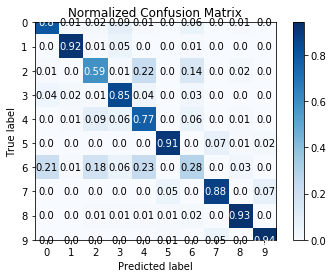

In [0]:
skplt.metrics.plot_confusion_matrix(train_set.targets,train_preds.argmax(dim=1), normalize=True)

### TensorBoard to visualize learning curves
The runs are logged to a file, and TensorBoard can produce a plot of the learning rate from all runs. The plot is accessed at the generated URL below.

In [0]:
# use ngrok to display TensorBoard on Colab
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


--2019-11-23 17:22:14--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.23.149.37, 52.4.202.19, 34.237.203.145, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.23.149.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  18.2MB/s    in 0.7s    

2019-11-23 17:22:15 (18.2 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './runs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')


The following should plot the learning curves for all training sessions that were logged to file. The plots are available from the Tensorboard link below.

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://396d2280.ngrok.io
